In [1]:
import numpy as np
import networkx as nx
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling
from scipy.stats import beta, dirichlet
from operator import add
import matplotlib.pyplot as plt
from operator import add

In [86]:
variables=list()
variables=['Recession','Burglary','Earthquake','Alarm']

In [87]:
alpha=0.8

In [88]:
orden=list()
orden=[['Alarm','Earthquake'],
       ['Alarm','Burglary']]

In [89]:
model = BayesianModel([('Recession', 'Burglary'),
                       ('Burglary','Alarm'),
                       ('Earthquake','Alarm')])

#Exogenas
cpd_Recession = TabularCPD(variable='Recession', variable_card=2, values=[[0.8, 0.2]])
cpd_Earthquake = TabularCPD(variable='Earthquake', variable_card=2, values=[[0.2, 0.8]])


cpd_Burglary_Recession = TabularCPD(variable='Burglary', variable_card=2, 
                           values=[[.1,.3], 
                                   [.9,.7]], 
                           evidence=['Recession'],
                           evidence_card=[2])

cpd_Alarm_Earthquake_Burglary = TabularCPD(variable='Alarm', variable_card=2, 
                                           values=[[0.9,0.3,0.1,0.05],
                                                   [0.1,0.7,0.9,0.95]],
                                           evidence=['Burglary', 'Earthquake'],
                                           evidence_card=[2,2])

model.add_cpds(cpd_Recession, cpd_Earthquake, cpd_Burglary_Recession, cpd_Alarm_Earthquake_Burglary)

infer = VariableElimination(model)
sampling = BayesianModelSampling(model)

In [90]:
class true_causal_model:
    def __init__(self,N,infer,sampling,model):
        self.num_variables=N
        self.infer=infer
        self.sampling=sampling
        self.true_model=model

    def action_simulator(self):
        response=dict()
        elements = [0,1]
        probabilities = [0.5,0.5]
        res=np.random.choice(elements, 1, p=probabilities)
        enf=np.random.choice(elements, 1, p=probabilities)
        response['Earthquake']=res[0]
        response['Recession']=enf[0]
        
        response['Burglary']=self.infer.map_query(['Burglary'],evidence={'Recession': response['Recession']})['Burglary']
        response['Alarm']=self.infer.map_query(['Alarm'],evidence={'Burglary': response['Burglary'],'Earthquake': response['Earthquake']})['Alarm']
        return(response)
        

In [91]:
true_model_class=true_causal_model(4,infer,sampling,model)

In [92]:
true_model_class.action_simulator()

{'Alarm': 1, 'Burglary': 1, 'Earthquake': 0, 'Recession': 1}

In [93]:
class structure_learning:
    def __init__(self, alpha, variables, true_model,model_simulator, orden):
        self.local_model=true_model ## Este es el directamente creado con PGMPY, no la clase true_causal_model
        self.simulator=model_simulator.action_simulator
        self.a=alpha
        self.orden=orden
        self.variables=variables
        self.causas_posibles=list()
        self.beliefs=dict()
        self.rondas=1.0
    
    def print_variables(self):
        return(self.variables)
    
    def print_orden(self):
        return(self.orden)
    
    def possible_causes(self):
        for i in range(len(self.variables)):
            for j in range(len(self.variables)):
                if(self.variables[i] != self.variables[j]):
                    lista_temp=[self.variables[i],self.variables[j]]
                    if(lista_temp not in self.orden):
                        self.causas_posibles.append(lista_temp)
        return(self.causas_posibles)
    
    def print_possible_causes(self):
        self.causas_posibles=self.possible_causes()
        return(self.causas_posibles)
    
    def initial_beliefs(self):
        self.causas_posibles=self.possible_causes()
        causas_posibles=self.causas_posibles
        for i in causas_posibles:
            i=str(i)
            self.beliefs[i]=np.random.rand(1).tolist()[0]
        return(self.beliefs)

    def observing_external(self):
        datos=self.simulator()
        return(datos)
    
    def belief_updating(self):
        self.rondas=self.rondas+1.0
        datos=self.observing_external()
        for i in self.causas_posibles:
            if(datos[i[0]]==1 and datos[i[1]]==1):
                i=str(i)
                if(self.beliefs[i]>0.5):
                    self.beliefs[i]=self.beliefs[i]+((self.a)*(1.0-self.beliefs[i])/(self.rondas))
                else:
                    self.beliefs[i]=self.beliefs[i]+((self.a)*(0.5-self.beliefs[i])/(self.rondas))
            elif(datos[i[0]]==1 and datos[i[1]]==0):
                i=str(i)
                self.beliefs[i]=((self.a)*(self.beliefs[i]))/(self.rondas)
 #           elif(datos[i[0]]==0 and datos[i[1]]==1):
 #               i=str(i)
 #               self.beliefs[i]=((self.a)*(self.beliefs[i]))/(self.rondas)
                #    if(datos[i[0]]==0 and datos[i[1]]==1):
                #        i=str(i)
                   # else:
                   #     if(datos[i[0]]==0 and datos[i[1]]==0):
#            else:
#                continue
        return(self.beliefs)

In [94]:
aprendizaje=structure_learning(alpha,variables,model,true_model_class,orden)

In [95]:
aprendizaje.print_possible_causes()

[['Recession', 'Burglary'],
 ['Recession', 'Earthquake'],
 ['Recession', 'Alarm'],
 ['Burglary', 'Recession'],
 ['Burglary', 'Earthquake'],
 ['Burglary', 'Alarm'],
 ['Earthquake', 'Recession'],
 ['Earthquake', 'Burglary'],
 ['Earthquake', 'Alarm'],
 ['Alarm', 'Recession']]

In [ ]:
      ['Burglary','Recession'],
      ['Recession','Earthquake']]

In [98]:
def experiments(M,N):
    RB=[0.0] * N
    RA=[0.0] * N
    BE=[0.0] * N
    BA=[0.0] * N
    ER=[0.0] * N
    EB=[0.0] * N
    EA=[0.0] * N
    AR=[0.0] * N
    BR=[0.0] *N
    RE=[0.0] *N
    
    for j in range(M):
        recession_burglary=list()
        recession_alarm=list()
        burglary_earthquake=list()
        burglary_alarm=list()
        earthquake_recession=list()
        earthquake_burglary=list()
        earthquake_alarm=list()
        alarm_recession=list()
        burglary_recession=list()
        recession_earthquake=list()
        resultados=dict()
    
        aprendizaje=structure_learning(alpha,variables,model,true_model_class,orden)
    
        initial=dict()
    
        initial=aprendizaje.initial_beliefs()
    
        for i in range(N):
            resultados=aprendizaje.belief_updating()
            recession_burglary.append(resultados["['Recession', 'Burglary']"])
            recession_alarm.append(resultados["['Recession', 'Alarm']"])
            burglary_earthquake.append(resultados["['Burglary', 'Earthquake']"])
            burglary_alarm.append(resultados["['Burglary', 'Alarm']"])
            earthquake_recession.append(resultados["['Earthquake', 'Recession']"])
            earthquake_burglary.append(resultados["['Earthquake', 'Burglary']"])
            earthquake_alarm.append(resultados["['Earthquake', 'Alarm']"])
            alarm_recession.append(resultados["['Alarm', 'Recession']"])
            burglary_recession.append(resultados["['Burglary', 'Recession']"])
            recession_earthquake.append(resultados["['Recession', 'Earthquake']"])
            
        RB=list( map(add, RB, recession_burglary) )
        RA=list( map(add, RA, recession_alarm) )
        BE=list( map(add, BE, burglary_earthquake) )
        BA=list( map(add, BA, burglary_alarm) )
        ER=list( map(add, ER, earthquake_recession))
        EB=list( map(add, EB, earthquake_burglary))
        EA=list( map(add, EA, earthquake_alarm))
        AR=list( map(add, AR, alarm_recession))
        BR=list( map(add, BR, burglary_recession))
        RE=list( map(add, RE, recession_earthquake))
        
    RB=[x / M for x in RB]
    RA=[x / M for x in RA]
    BE=[x / M for x in BE]
    BA=[x / M for x in BA]
    ER=[x / M for x in ER]
    EB=[x / M for x in EB]
    EA=[x / M for x in EA]
    AR=[x / M for x in AR]
    BR=[x / M for x in BR]
    RE=[x / M for x in RE]
        
    plt.figure(figsize=(20,20))
    plt.plot(RB,label='Recession causes Burglary',linestyle='-',marker='o',markersize=10)
    plt.plot(RA,label='Recession causes Alarm',linestyle='-.',marker='s',markersize=10)
    plt.plot(BE,label='Burglary causes Earthquake',linestyle='--',marker='D',markersize=10)
    plt.plot(BA,label='Burglary causes Alarm',linestyle='-',marker='*',markersize=10)
    plt.plot(ER,label='Earthquake causes Recession',linestyle='-',marker='1',markersize=10)
    plt.plot(EB,label='Earthquake causes Burglary',linestyle='-',marker='2',markersize=10)
    plt.plot(EA,label='Earthquake causes Alarm',linestyle='-',marker='3',markersize=10)
    plt.plot(AR,label='Alarm causes Recession',linestyle='-',marker='4',markersize=10)
    plt.plot(BR,label='Burglary causes Recession',linestyle='-',marker='4',markersize=10)
    plt.plot(RE,label='Recession causes Earthquake',linestyle='-',marker='4',markersize=10)
    leg = plt.legend(loc='lower right', shadow=True, fontsize=30)
    plt.xlim([0, N])
    plt.ylim([0, 1.005])
    plt.xlabel("Rounds",fontsize=20)
    plt.ylabel("Average Beliefs in N repetitions",fontsize=20)
    plt.savefig('results_500_50_alarm.png')

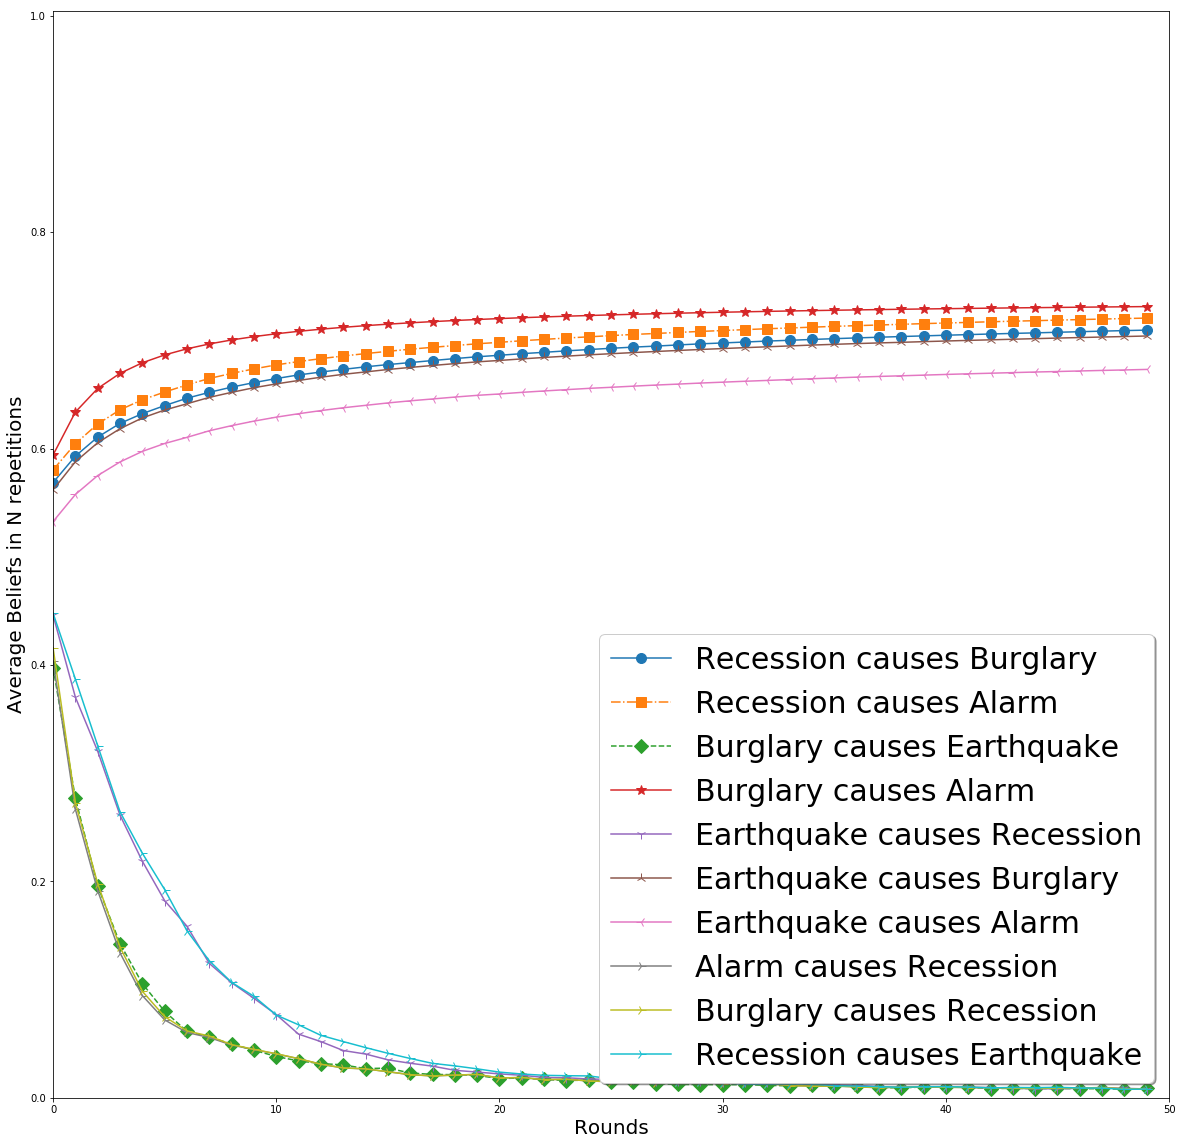

In [99]:
experiments(500,50)